# SAVESPOTS
[Videogames EDA](#Videogames-EDA) <br>
[Reviews EDA](#Reviews-EDA) <br>

[RECOMMENDER MODEL BASED OFF USER RATINGS: USER BASED FILTERING](#RECOMMENDER-MODEL-BASED-OFF-USER-RATINGS:-USER-BASED-FILTERING) <br>
[RECOMMENDER MODEL BASED OFF DESCRIPTION: CONTENT BASED](#RECOMMENDER-MODEL-BASED-OFF-DESCRIPTION:-CONTENT-BASED) <br>
[DETERMINING RMSE](#DETERMINING-RMSE) <br>
[HANDLING COLD START](#HANDLING-COLD-START) <br>


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#autoreload to take in changes from outside
%load_ext autoreload
%autoreload 2

In [3]:
import math
import string
import re
from datetime import datetime
from collections import Counter

In [4]:
# from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
from src.EDA import EDA
eda = EDA()

In [285]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
    mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
    
    return mz_table

In [281]:
videogames = pd.read_json('Data/meta_Video_Games.json', lines=True)
reviews = pd.read_json('Data/Video_Games.json', lines=True)

## Cleaning Video Games DF

In [129]:
#drop also_buy, also_view, date, details, similar_item, tech1, tech2
main_videogames = videogames.copy()
main_videogames.drop(columns=['also_buy', 'also_view', 'date', 'details', 'similar_item', 'tech1', 'tech2'], inplace=True)

In [130]:
# #Check for missing values #1
# missing_zero_values_table(main_videogames)

### Changing missing title names to their actual titles

In [131]:
indexes = [467, 11873, 11876, 11878, 13376, 24782, 24785, 24787, 29674, 38379, 52373, 61916, 63263, 64453]
title_names = ['Dune 2000', 'Virtual Stick Pro', 'Saturn Control Pad Mist Gray', 'Saturn control pad', 'Dune 2000', 
               'Virtual Stick Pro', 'Saturn Control Pad Mist Gray', 'Saturn control pad', 'Sega Vertual Stick', 'Puppet Motel',
               'Friendship Collection New Life','Ranch Story Connected New World', 'Kirby Triple Deluxe', 'Detective Conan Phantom Rhapsody']

In [132]:
for idx, val in enumerate(indexes):
    main_videogames.loc[val, 'title'] = title_names[idx]

In [133]:
# #Check for missing values #2
# missing_zero_values_table(main_videogames)

In [134]:
float_puncs = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'
str1=""

def remove_puncs_into_floats(item):
    table = str.maketrans('','', float_puncs)
    stripped = [i.translate(table) for i in item]
    return float(str1.join(stripped))

#change missing prices to -1, and change string prices to floats
prices = main_videogames.price.apply(lambda x: float(-1) if isinstance(x, float) else remove_puncs_into_floats(x))

In [135]:
#Since 81.7% of prices are missing, and not doing a recommender based on price, remove price column.
#Since images are not being used to create a recommender, remove image column.
main_videogames.drop(columns=['price','image'],inplace=True)

In [136]:
# #Check for missing values #3
# missing_zero_values_table(main_videogames)

In [137]:
def remove_puncs(item):
    table = str.maketrans('','', float_puncs)
    stripped = [i.translate(table) for i in item]
    return str1.join(stripped)

In [138]:
#converting rank strings to just rank numbers
rank = main_videogames["rank"].apply(lambda x: "999999999" if isinstance(x, float) else remove_puncs(x).split(" ",1)[0])

In [139]:
rank = rank.apply(lambda x: x.split("i", 1)[0])

In [140]:
#find messed up values in rnak #4
for idx, val in enumerate(rank):
    if val == 'productDescr':
        print(idx)

52316


In [141]:
rank[52316] = 999999999

In [142]:
rank = rank.apply(lambda x: float(x))

In [143]:
main_videogames['rank']=rank

In [144]:
# #Check for missing values #4
# missing_zero_values_table(main_videogames)

In [145]:
#Change all nulls in main_cat into 'Video Games'
main_cat = main_videogames['main_cat'].apply(lambda x: 'Video Games' if isinstance(x, float) else x)
main_videogames['main_cat'] = main_cat

#Change all nulls in features into 'no_features'
features = main_videogames['feature'].apply(lambda x: 'no_features' if isinstance(x, float) else x)
main_videogames['feature'] = features

#Change all null in description into 'no_description'
description = main_videogames['description'].apply(lambda x: 'no_description' if isinstance(x, float) else x)
main_videogames['description'] = description

In [146]:
# #Check for missing values #5
# missing_zero_values_table(main_videogames)

In [147]:
#Change null brands to 'no_brand'
brand = main_videogames['brand'].apply(lambda x: 'no_brand' if isinstance(x, float) else x)

#Remove html taggings "by\n \n"
filter_tag = 'by\n    \n    '
brand = brand.apply(lambda x: x[12:] if filter_tag in x else x)
main_videogames['brand'] = brand

#Change null category to ['Video Games']
category = main_videogames['category'].apply(lambda x: ['Video Games'] if isinstance(x, float) else x)
main_videogames['category'] = category

In [148]:
#Check for missing values #6
missing_zero_values_table(main_videogames)

Your selected dataframe has 8 columns and 84893 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [149]:
#Change category into a full string
str2 = " "
category = main_videogames['category'].apply(lambda x: str2.join(x) if isinstance(x, list) else x)
main_videogames['category'] = category

#Change description into a full string
description = main_videogames['description'].apply(lambda x: str2.join(x) if x!='no_description' else x)
main_videogames['description'] = description

#Change feature into a full string
feature = main_videogames['feature'].apply(lambda x: str2.join(x) if x!='no_features' else x)
main_videogames['feature'] = feature

In [150]:
#manually change categories to their sub category
category = main_videogames['category'].apply(lambda x: x[12:] if x!='Video Games' else x)
category = category.apply(lambda x: x[len('Retro Gaming & Microconsoles '):] if 'Retro Gaming & Microconsoles ' in x else x)
main_videogames['category'] = category

#drop main_cat
main_videogames.drop('main_cat', 1, inplace=True)

## Save to new csv file

In [168]:
main_videogames.to_csv('Data/main_videogames.csv')

In [495]:
test= pd.read_csv('Data/main_videogames.csv', index_col=0)

In [501]:
test.shape

(798397, 7)

In [502]:
test.drop_duplicates(inplace=True)

In [507]:
test['title'].fillna("no_title", inplace=True)

In [509]:
test.drop(columns=['category','brand','rank','description','feature'], inplace=True)

In [511]:
test.to_csv('Data/asin_title.csv')

## Copy/load to test filling out descriptions and features

In [8]:
#makes a copy
full_videogames = main_videogames.copy()

In [13]:
#or load csv
full_videogames = pd.read_csv('Data/main_videogames.csv')

In [249]:
#drop duplicates
full_videogames.drop_duplicates(inplace=True)

In [250]:
#too many different categories. removing excessive details
category = full_videogames['category'].apply(lambda x: str(x).split("  ")[0].strip() if len(str(x).split("  "))>1 else str(x).strip())
full_videogames['category'] = category

In [251]:
#using excessive details from long categories to fill in empty descriptions and featuers
description_feature = full_videogames['category'].apply(lambda x: x.split("  ")[1].strip() if len(x.split("  "))>1 else x.strip())
descriptions = []
features = []

for idx, val in enumerate(full_videogames['description']):
    if val == 'no_description':
        descriptions.append(description_feature[idx])
    else:
        descriptions.append(val)

for idx, val in enumerate(full_videogames['feature']):
    if val == 'no_features':
        features.append(description_feature[idx])
    else:
        features.append(val)

full_videogames['description'] = descriptions
full_videogames['feature'] = features

In [ ]:
# sorted(full_videogames.category.unique())

In [656]:
def platform_type(item):
    item = item.lower()
    if '3do' in item: return '3DO'
    elif 'Atari 2600'.lower() in item: return 'Atari2600'
    elif 'Atari 5200'.lower() in item: return 'Atari5200'
    elif 'Atari 7800'.lower() in item: return 'Atari7800'
    elif 'Atari Jaguar'.lower() in item: return 'AtariJaguar'
    elif 'Atari Lynx'.lower() in item: return 'AtariLynx'
    elif 'ColecoVision'.lower() in item: return 'ColecoVision'
    elif 'Commodore 64'.lower() in item: return 'Commodore64'
    elif 'Commodore Amiga'.lower() in item: return 'CommodoreAmiga'
    elif 'Mac'.lower() in item: return 'Mac'
    elif 'PC'.lower() in item: return 'PC'
    elif 'Intellivision'.lower() in item: return 'Intellivision'
    elif 'Nintendo DS'.lower() in item: return 'NintendoDS'
    elif 'Nintendo 64'.lower() in item: return 'Nintendo64'
    elif 'Nintendo 3DS'.lower() in item: return 'Nintendo3DS'
    elif 'Nintendo Switch'.lower() in item: return 'NintendoSwitch'
    elif 'PlayStation 2'.lower() in item: return 'PlayStation2'
    elif 'PlayStation 3'.lower() in item: return 'PlayStation3'
    elif 'PlayStation 4'.lower() in item: return 'PlayStation4'
    elif 'PlayStation Vita'.lower() in item: return 'PlayStationVita'
    elif 'PlayStation'.lower() in item: return 'PlayStation'
    elif 'PSP'.lower() in item: return 'PSP'
    elif 'Wii U'.lower() in item: return 'WiiU'
    elif 'Wii'.lower() in item: return 'Wii'
    elif 'Xbox 360'.lower() in item: return 'Xbox360'
    elif 'Xbox One'.lower() in item: return 'XboxOne'
    elif 'Xbox'.lower() in item: return 'Xbox'
    elif 'Linux'.lower() in item: return 'Linux'
    elif 'NEOGEO Pocket'.lower() in item: return 'NEOGEOPocket'
    elif 'NES'.lower() in item: return 'NES'
    elif 'Ouya'.lower() in item: return 'Ouya'
    elif 'Virtual Reality'.lower() in item: return 'VirtualReality'
    elif 'Retro Gaming & Microconsoles'.lower() in item: return 'RetroGaming & Microconsoles'
    elif 'Sega CD'.lower() in item: return 'Sega CD'
    elif 'Sega Dreamcast'.lower() in item: return 'SegaDreamcast'
    elif 'Sega Game Gear'.lower() in item: return 'SegaGameGear'
    elif 'Sega Genesis'.lower() in item: return 'SegaGenesis'
    elif 'Sega Master System'.lower() in item: return 'SegaMasterSystem'
    elif 'Sega Saturn'.lower() in item: return 'SegaSaturn'
    elif 'Super Nintendo'.lower() in item: return 'SuperNintendo'
    elif 'TurboGrafx 16'.lower() in item: return 'TurboGrafx16'
    elif 'GameCube'.lower() in item: return 'GameCube'
    elif 'Advance'.lower() in item: return 'GameBoyAdvance'
    elif 'Color'.lower() in item: return 'Game Boy Color'
    elif 'Game Boy'.lower() in item: return 'GameBoy'
    else: return "none"

In [253]:
def product_type(item):
    if 'Games' in item: return 'Game'
    elif 'Controller' in item: return 'Controller'
    elif 'Joysticks' in item: return 'Joystick'
    elif 'Racing Wheel' in item: return 'Racing Wheel'
    elif 'Gamepads' in item: return 'Gamepads'
    elif 'Consoles' in item: return 'Console'
    elif 'Cables' in item: return 'Cables'
    elif 'System' in item: return 'System'
    elif 'Batteries' in item: return 'System'
    elif 'Headset' in item: return 'Headset'
    elif 'DLC' in item: return 'DLC'
    elif 'Figures' in item: return 'Figures'    
    elif 'Mounts' or 'Brackets' or 'Stands' in item: return 'Mounts'    
    elif 'Subscription' in item: return 'Subscription'
    elif 'Accessories' in item: return 'Accessories'

In [254]:
#Get the platform and product type of each item
platform1 = full_videogames['category'].apply(lambda x: platform_type(str(x)))
platform2 = full_videogames['description'].apply(lambda x: platform_type(str(x)))
platform3 = full_videogames['feature'].apply(lambda x: platform_type(str(x)))
product = full_videogames['category'].apply(lambda x: product_type(str(x)))

#combines all the text from three columns to determine the platform 
platform = platform1 + ' ' + platform2 + ' ' + platform3
platform = platform.apply(lambda x: platform_type(x))
#None means that the platform was never mentioned in the entire posting

full_videogames['platform'] = platform
full_videogames['product'] = product

In [10]:
#TODO: Include average rating of items

## Videogames EDA

In [27]:
from src.EDA import EDA
eda = EDA()

In [323]:
?eda #update docstring

Object `eda #update docstring` not found.


In [24]:
full_videogames = pd.read_csv('Data/full_videogames.csv', index_col=0)

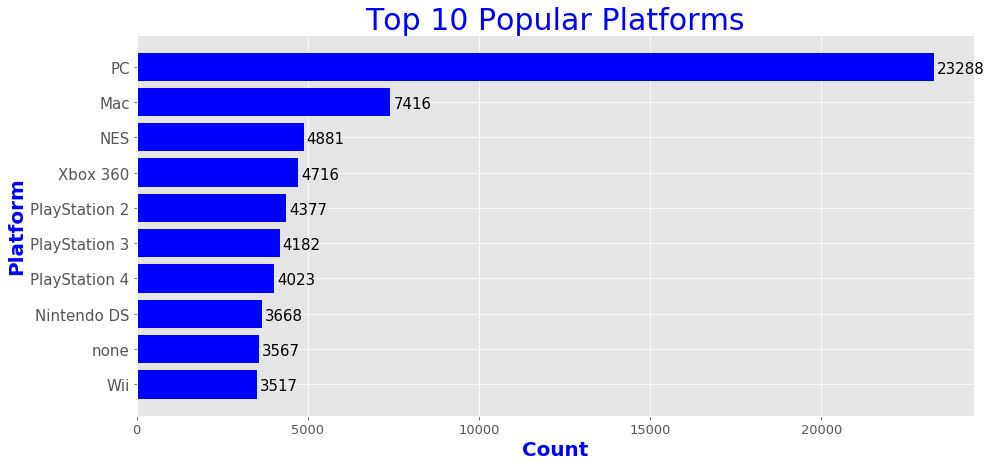

Number of Unique Platforms:  45


In [30]:
#1. Top 10 Platforms BarH
platform_counts = full_videogames['platform'].value_counts()
platform_list = []
count_list = []

for key, val in platform_counts.items():
    platform_list.append(str(key))
    count_list.append(val)

#plot here
eda.print_bar(platform_list[:10][::-1], count_list[:10][::-1], x_label='Count', y_label='Platform', 
              title='Top 10 Popular Platforms', orientation='hort')

#print number of uniques
print('Number of Unique Platforms: ', full_videogames['platform'].nunique())

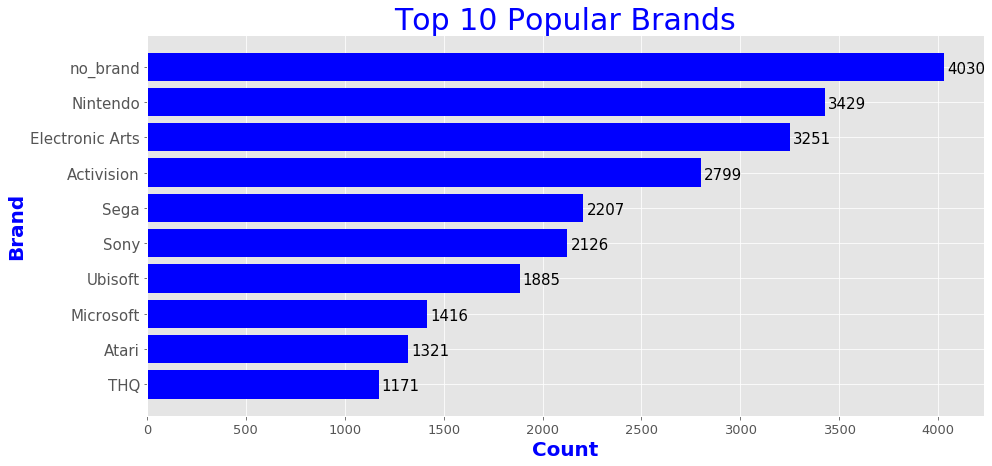

Number of Unique Brands:  7779


In [31]:
#2. Top 10 Brand BarH
brand_counts = full_videogames['brand'].value_counts()
brand_list = []
count_list = []

for key, val in brand_counts.items():
    brand_list.append(str(key))
    count_list.append(val)

#plot here
eda.print_bar(brand_list[:10][::-1], count_list[:10][::-1], x_label='Count', y_label='Brand', 
              title='Top 10 Popular Brands', orientation='hort')

#print number of uniques
print('Number of Unique Brands: ', full_videogames['brand'].nunique())

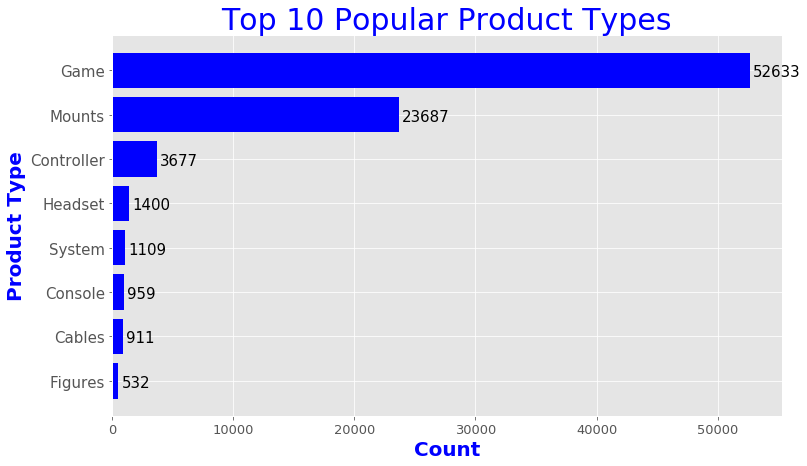

In [36]:
#3. Top 10 Product Type BarH
product_counts = full_videogames['product'].value_counts()
product_list = []
count_list = []

for key, val in product_counts.items():
    product_list.append(str(key))
    count_list.append(val)

#plot here
eda.print_bar(product_list[:10][::-1], count_list[:10][::-1], x_label='Count', y_label='Product Type', 
              title='Top 10 Popular Product Types', orientation='hort')

##### Done with video games EDA

In [270]:
#Save to new CSV
full_videogames.to_csv('Data/full_videogames.csv')

### Copy dataframe, then start Shrinking to unique values

In [671]:
simple_videogames = full_videogames.copy()

In [672]:
simple_videogames.drop('category', 1, inplace=True)

In [673]:
# platform = simple_videogames['platform'].apply(lambda x: platform_type(x))
# simple_videogames['platform'] = platform

In [675]:
description = simple_videogames['title'] + ' ' + simple_videogames['brand'] + ' ' + simple_videogames['description'] + ' ' + simple_videogames['feature'] + ' ' + simple_videogames['platform'] + ' ' + simple_videogames['product']

In [676]:
simple_videogames.drop(columns = ['title','brand','feature','product'], inplace=True)
simple_videogames['description'] = description

In [677]:
simple_videogames.head()
#would we want to have unique words in the description? or keep nuber of words 

,Unnamed: 0,rank,asin,description,platform
0,0,2623937.0,0042000742,Reversi Sensory Challenger Fidelity Electronic...,PC
1,1,67231.0,0078764343,Medal of Honor: Warfighter - Includes Battlefi...,Xbox360
2,2,134433.0,0276425316,street fighter 2 II turbo super nintendo snes ...,SuperNintendo
3,3,105263.0,0324411812,Xbox 360 MAS STICK MAS SYSTEMS MAS's Pro Xbox ...,PC
4,4,92397.0,0439335310,Phonics Alive! 3: The Speller Advanced Softwar...,PC


In [678]:
#save to csv
simple_videogames.to_csv('Data/simple_videogames.csv')

# """""""""""""""""""""""'

# Cleaning Reviews DF ~

In [282]:
#change image to 0 or 1
main_reviews = reviews.copy()
image = [0 if isinstance(i,float) else 1 for i in main_reviews.image]
main_reviews['image'] = image

In [283]:
#drop columns = reviewTime, reviewName, style, vote
main_reviews.drop(columns=['reviewTime', 'reviewerName', 'style', 'vote'], inplace=True)

### Handle Missing

In [286]:
missing_zero_values_table(main_reviews)

Your selected dataframe has 8 columns and 2565349 Rows.
There are 2 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
reviewText,0,1715,0.1,1715,0.1,object
summary,0,811,0.0,811,0.0,object


In [287]:
np.unique(reviews.reviewText.isna(), return_counts=True)

(array([False,  True]), array([2563634,    1715]))

In [288]:
np.unique(reviews.summary.isna(), return_counts=True)

(array([False,  True]), array([2564538,     811]))

In [289]:
reviewText = main_reviews.reviewText.apply(lambda x: 'no_text_was_given' if isinstance(x, float) else x)

In [290]:
summary = main_reviews.summary.apply(lambda x: 'no_summary_given' if isinstance(x, float) else x)

In [291]:
main_reviews['reviewText'] = reviewText
main_reviews['summary'] = summary

In [292]:
missing_zero_values_table(main_reviews)

Your selected dataframe has 8 columns and 2565349 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [293]:
#change verified values to 0 or 1
verified = main_reviews['verified'].apply(lambda x: 1 if x==True else 0)
main_reviews['verified'] = verified

In [294]:
#change unixReviewTime to corresponding day/week/month/year
ReviewTime = pd.Timestamp(main_reviews['unixReviewTime'][0], unit='s')
day = ReviewTime.dayofyear
week = ReviewTime.weekofyear
month = ReviewTime.month
year = ReviewTime.year

main_reviews['day'] = day
main_reviews['week'] = week
main_reviews['month'] = month
main_reviews['year'] = year

In [295]:
main_reviews.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,image,day,week,month,year
0,1,1,A21ROB4YDOZA5P,0439381673,I used to play this game years ago and loved i...,Did not like this,1402272000,0,160,24,6,2014
1,3,1,A3TNZ2Q5E7HTHD,0439381673,The game itself worked great but the story lin...,Almost Perfect,1399680000,0,160,24,6,2014
2,4,1,A1OKRM3QFEATQO,0439381673,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,0,160,24,6,2014
3,1,1,A2XO1JFCNEYV3T,0439381673,The product description should state this clea...,does not work on Mac OSX,1391731200,0,160,24,6,2014
4,4,1,A19WLPIRHD15TH,0439381673,I would recommend this learning game for anyon...,Roughing it,1389830400,0,160,24,6,2014


In [296]:
#Save dataframe to CSV
main_reviews.to_csv('Data/main_reviews.csv')

## Reviews EDA

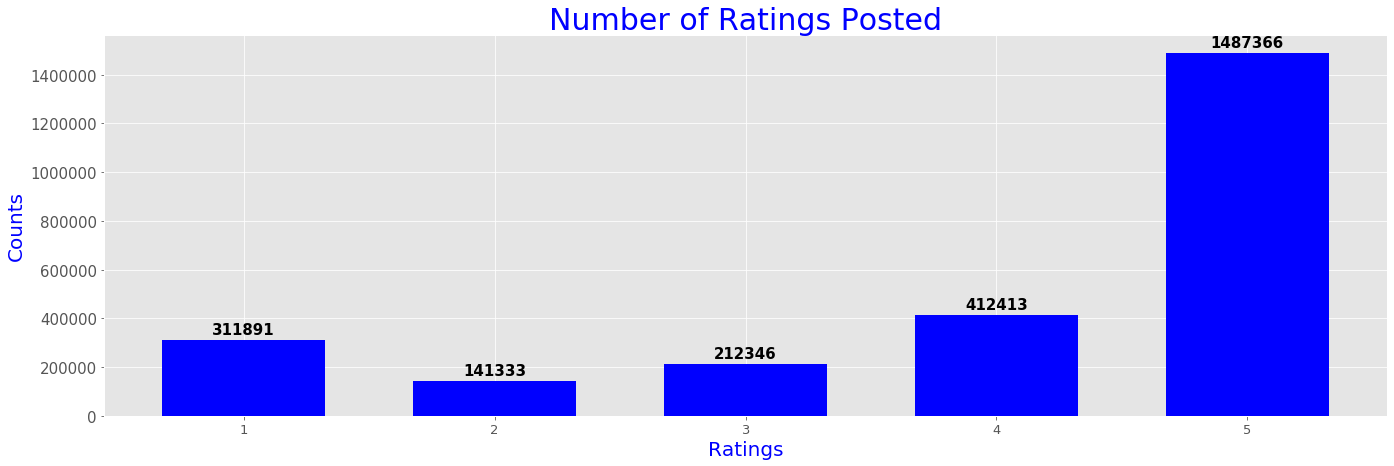

In [329]:
#1. Barplot on ratings given
ratings = []
counts = []

for idx, val in main_reviews['overall'].value_counts().sort_index().items():
    ratings.append(idx)
    counts.append(val)

#Graph Barplot
eda.print_bar(x=ratings, y=counts, x_label='Ratings', y_label='Counts', title='Number of Ratings Posted', orientation='vert')

# plt.savefig('Images/Number_of_Ratings.jpg')

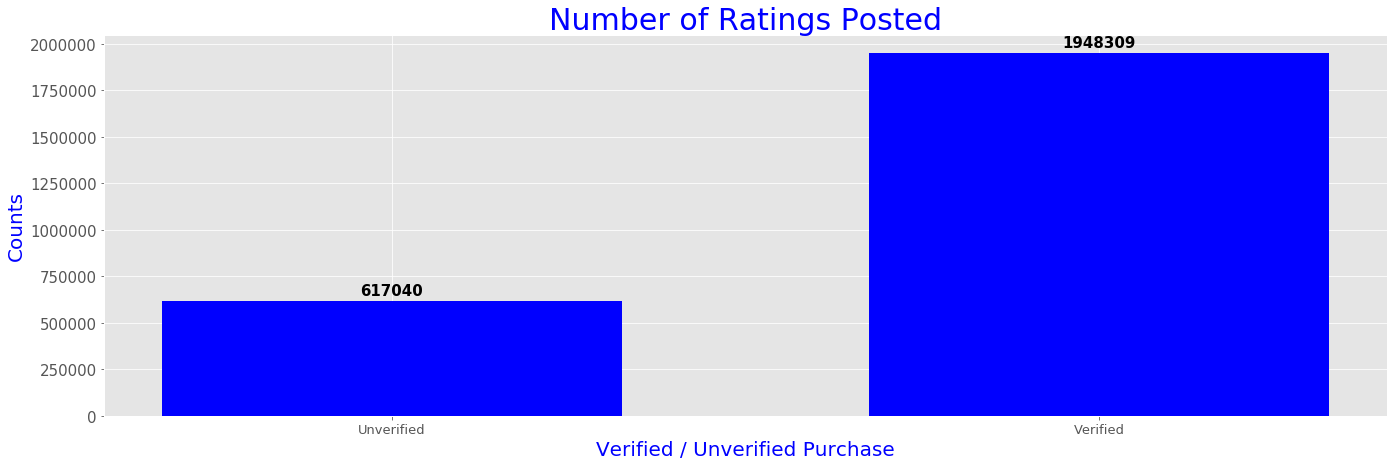

In [332]:
#2. Barplot on Verified vs Unverified Purchased
verified_unverified_labels = ['Unverified', 'Verified']
verified_unverified_count = [0, 1]

for idx, val in main_reviews['verified'].value_counts().sort_index().items():
    verified_unverified_count[idx] = val

#Graph Barplot
eda.print_bar(x=verified_unverified_labels, y=verified_unverified_count, x_label='Verified / Unverified Purchase', y_label='Counts', title='Number of Ratings Posted', orientation='vert')

# plt.savefig('Images/Verified_vs_Unverified.jpg')

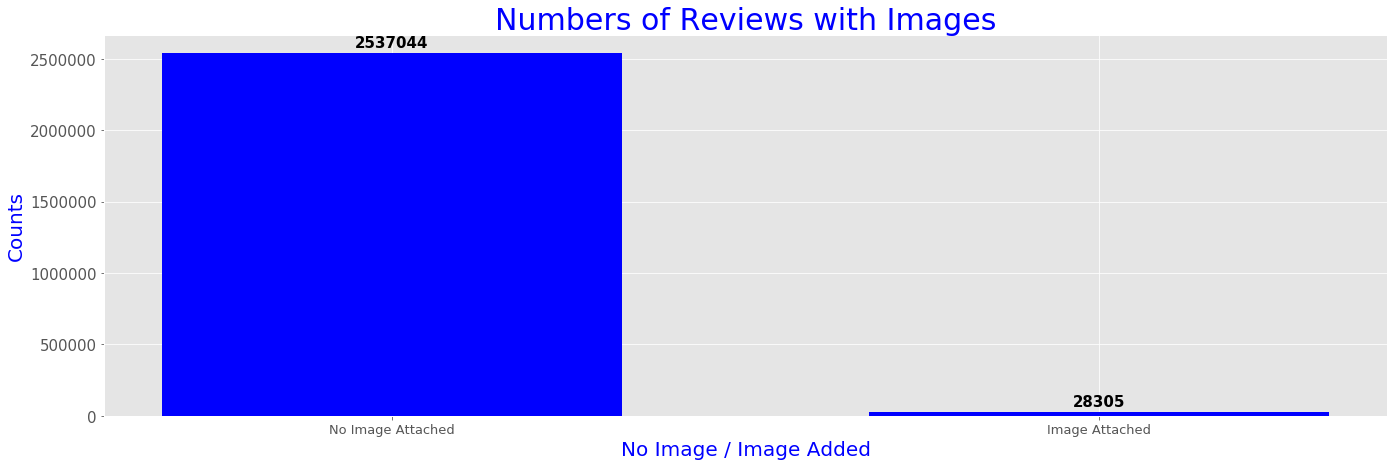

In [333]:
#3. Barplot on number of reviews with image attached
image_labels = ['No Image Attached', 'Image Attached']
image_counts = [0, 1]

for idx, val in main_reviews['image'].value_counts().sort_index().items():
    image_counts[idx] = val
    
#Graph barplot
eda.print_bar(x=image_labels, y=image_counts, x_label='No Image / Image Added', y_label='Counts', title='Numbers of Reviews with Images', orientation='vert')

# plt.savefig('Images/Verified_vs_Unverified.jpg')

# ^ END UP EDA ^

### ==============================================================

## START OF RECOMMENDER SYSTEM

In [92]:
from src.EDA import EDA
eda = EDA()

### Ratings - Filtering out reviewerIDs with less than 5 reviews

In [36]:
#first make copy of reviews
tokenized_reviews_df = pd.read_csv('Data/simple_reviews.csv')

In [41]:
tokenized_reviews_df.head(3)

,rating,reviewerID,asin,reviewText
0,1,A21ROB4YDOZA5P,0439381673,I used to play this game years ago and loved i...
1,3,A3TNZ2Q5E7HTHD,0439381673,The game itself worked great but the story lin...
2,4,A1OKRM3QFEATQO,0439381673,I had to learn the hard way after ordering thi...


In [38]:
tokenized_reviews_df.drop(columns=['Unnamed: 0'],inplace=True)

In [40]:
#get the value counts of times a reviewer has reviewed items
reviewerID_reviewCounts = tokenized_reviews_df['reviewerID'].value_counts()

#get a list of reviewer ID that has reviewed more than 5 times
reviewerID_indexes = reviewerID_reviewCounts[reviewerID_reviewCounts > 5].index


In [43]:
#filter dataframe to hold just the rows with needed reviewerID
rating_table = tokenized_reviews_df[tokenized_reviews_df['reviewerID'].isin(reviewerID_indexes)] 

In [44]:
print('Table shape after filtering out reviewerID: ', rating_table.shape)

Table shape after filtering out reviewerID:  (486765, 4)


### Ratings - Filtering out asins with less than 5 reviews

In [45]:
#get the value counts of times an item has been reviewed
asinID_reviewCounts = tokenized_reviews_df['asin'].value_counts()

#get a list of asin that has reviewed more than 5 times
asinID_indexes = asinID_reviewCounts[asinID_reviewCounts > 5].index


In [46]:
#filter dataframe to hold just the rows with needed asins
rating_table = rating_table[rating_table['asin'].isin(asinID_indexes)] 

In [47]:
print('Table shape after filtering out asinD: ', rating_table.shape)

Table shape after filtering out asinD:  (468297, 4)


In [62]:
rating_table.drop('reviewText',1,inplace=True)

In [63]:
rating_table.to_csv('Data/rating_table.csv')

## RECOMMENDER MODEL BASED OFF ITEM RATINGS: ITEM BASED FILTERING

In [275]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
def replace_asin(x):
    return simple_videogames[simple_videogames['asin']==x]['description'].value[0]

In [7]:
def pearson(s1, s2):
    s1_c = s1-s1.mean()
    s2_c = s2-s2.mean()
    return np.sum(s1_c * s2_c)/np.sqrt(np.sum(s1_c**2)*np.sum(s2_c**2))

In [8]:
def get_recs(asin_id, rating_table, num, similarity_type='pearson'):
    
    recommendations = []
    
    #Pearson Similarity
    if similarity_type=='pearson':
        similarity_calculator = pearson
    
    #Cosine Similarity
    elif similarity_type=='cosine similarity':
        similarity_calculator = cosine_similarity

#     #Jaccard Similarity [find/make actual jaccard function]
#     elif similarity_type=='jaccard':
#         cor = jaccard        
    
    for asin in rating_table.columns:
        if asin == asin_id:
            continue
                
        cor = similarity_calculator(rating_table[asin_id], rating_table[asin])

        #checks if the correlation is nan; if so, then continue
        if np.isnan(cor):
            continue
        else:
            recommendations.append((asin, cor))
        
    recommendations.sort(key=lambda tup: tup[1], reverse=True)
    return recommendations[:num]

### Ratings - TESTING RECOMMNDER

In [318]:
rating_table = pd.read_csv('Data/rating_table.csv', index_col=0)

In [281]:
rating_table = rating_table.pivot_table(index=['reviewerID'],columns=['asin'], values='rating')


In [282]:
#how should I be handling nan values? collaborative filtering or just 0s?
rating_table = rating_table.fillna(0)

In [473]:
#TODO:
rating_table.to_csv('Data/pivoted_rating_table.csv')

pandas.core.frame.DataFrame

In [37]:
rating_table = pd.read_csv('Data/smaller_rating_table_25000.csv', index_col=0)
asin_title = pd.read_csv('Data/asin_title.csv', index_col=0)

In [11]:
recs = get_recs('0700026398', rating_table, 10)

In [12]:
extracted_asin = []
for i in recs:
    extracted_asin.append(i[0])

In [23]:
asin_title[asin_title['asin'].isin(extracted_asin)]['title'][9]

'G-Force - PC'

In [321]:
asin_description = simple_videogames[['asin','description']]


In [483]:
asin_description.to_csv('Data/asin_description.csv')

In [488]:
rating_table.index_col=0

In [490]:
rating_table.shape

(44238, 30607)

In [491]:
smaller_rating_table_25000_by_25000 = rating_table.iloc[:25000,:25000]

In [493]:
smaller_rating_table_25000_by_25000.to_csv('Data/smaller_rating_table_25000.csv')


In [38]:
smaller_rating_table_15000_by_15000 = rating_table.iloc[:15000,:15000]


In [39]:
smaller_rating_table_15000_by_15000.shape

(15000, 15000)

In [ ]:
smaller_rating_table_15000_by_15000.to_csv('Data/smaller_rating_table_15000.csv')

In [120]:
#save recommendation table
rating_table.to_csv('Data/recommender_rating_table.csv')

[Back to top](#SAVESPOTS)

### ==============================================================

### DROP DUPLICATES, FILL NANS, AND FILTER OUT PRODUCTS WITHOUT ANY RATINGS

In [7]:
#Copy main_reviews
simple_reviews = pd.read_csv('Data/main_reviews.csv')

#load up simple_videogames from csv
simple_videogames = pd.read_csv('Data/simple_videogames.csv')

#Cleaning out rows without asin value
simple_videogames = simple_videogames[simple_videogames['asin'].notna()]

#Drop duplicates
simple_videogames.drop_duplicates('asin', inplace=True)

#Check which asin has not been rated before
#unique asin in reviews
main_reviews_unique_asin = simple_reviews['asin'].to_list()
#unique asin in videogames
main_videogames_unique_asin = simple_videogames['asin'].to_list()

#Get the asin values that are not in both
not_reviewed_asin = np.setdiff1d(main_videogames_unique_asin, main_reviews_unique_asin)

#manually remove the different asin values
simple_videogames = simple_videogames[simple_videogames['asin']!='B0001XASGW']
simple_videogames = simple_videogames[simple_videogames['asin']!='B000WCEENK']

#convert asin to sorted list to compare with asin from reviews and videogames
simple_reviews_asin = np.sort(main_reviews_unique_asin)
simple_videogames_asin = np.sort(simple_videogames['asin'])
similar = simple_reviews_asin == simple_videogames_asin
np.unique(similar)

#Alternate way 
# Counter(similar).keys()
# Counter(similar).values()

In [21]:
simple_videogames.to_csv('Data/THE_SIMPLE_VIDEOGAMES.csv')

# RECOMMENDER MODEL BASED OFF DESCRIPTION: CONTENT BASED

In [21]:
simple_videogames.read_csv('Data/THE_SIMPLE_VIDEOGAMES.csv')

In [26]:
simple_videogames['bag_of_words'] = simple_videogames['description'] + ' ' + simple_videogames['platform']

In [812]:
#DO NOT RUN THIS ANYMORE
#adding platform to videogame description
gameplatforms = simple_videogames[['asin','platform']]

#matches up asin with platforms
review_platforms = simple_reviews['asin'].apply(lambda x: gameplatforms[gameplatforms['asin']==x].iloc[0].platform)

#set platform column to the reviews
simple_reviews['platform'] = review_platforms

#combine all words to be tokenized
reviewText = simple_reviews['reviewText'] + ' ' + simple_reviews['summary'] + ' ' + simple_reviews['platform']

simple_reviews['reviewText'] = reviewText
simple_reviews.drop(columns=['summary','platform'], inplace=True)

#rename 'overall' column to 'rating'
simple_reviews.rename(columns={'overall':'rating'}, inplace=True)

In [82]:
simple_reviews.to_csv('Data/simple_reviews.csv')

## Add average ratings to videogames

In [584]:
#Get average rating of each asin
ratings = simple_reviews.groupby('asin')['rating'].mean()

asin
0042000742    5.000000
0078764343    4.750000
0276425316    5.000000
0324411812    1.000000
0439335299    3.000000
                ...   
B01HJ14OT0    5.000000
B01HJ14TTA    3.000000
B01HJ1521Y    5.000000
B01HJC33WS    4.590909
B01HJEBIAA    4.233333
Name: rating, Length: 71982, dtype: float64

In [716]:
#sort videogames df by asin values
simple_videogames.sort_values(by = 'asin', inplace=True)

#add ratings to videogames
simple_videogames['rating'] = ratings.values

In [763]:
#replace nan descriptions with empty string
simple_videogames['description'].fillna("", inplace=True)

In [790]:
simple_videogames[simple_videogames['description'].isna()]

,rank,asin,description,platform,rating,tokens


### Tokenize simple_videogames_description

In [96]:
simple_videogames.head()

,rank,asin,description,platform,rating,bag_of_words
0,2623937.0,0042000742,Reversi Sensory Challenger Fidelity Electronic...,PC,5.00,Reversi Sensory Challenger Fidelity Electronic...
1,67231.0,0078764343,Medal of Honor: Warfighter - Includes Battlefi...,Xbox360,4.75,Medal of Honor: Warfighter - Includes Battlefi...
2,134433.0,0276425316,street fighter 2 II turbo super nintendo snes ...,SuperNintendo,5.00,street fighter 2 II turbo super nintendo snes ...
3,105263.0,0324411812,Xbox 360 MAS STICK MAS SYSTEMS MAS's Pro Xbox ...,PC,1.00,Xbox 360 MAS STICK MAS SYSTEMS MAS's Pro Xbox ...
4,117477.0,0439335299,Phonics Alive! 2 The Sound Blender Advanced So...,PC,3.00,Phonics Alive! 2 The Sound Blender Advanced So...


In [100]:
#remove na values
simple_videogames['bag_of_words'] = simple_videogames['bag_of_words'].fillna("")

In [101]:
# #Tokenizes bag of words for count vectorizing later
# simple_videogames_tokens = simple_videogames['bag_of_words'].apply(lambda x: eda.personal_tokenize(x))

In [116]:
simple_videogames_tokens[:4]

0    reversi sensori challeng fidel electron pc gam...
1    medal honor warfight includ battlefield 4 beta...
2    street fighter 2 ii turbo super nintendo snes ...
Name: bag_of_words, dtype: object

In [105]:
simple_videogames['bag_of_words'] = simple_videogames_tokens

In [107]:
#save to csv
simple_videogames.to_csv('Data/videogames_w_bag_of_words.csv')

In [8]:
#load from csv
simple_videogames = pd.read_csv('Data/videogames_w_bag_of_words.csv', index_col=0)
videogame_description_table = simple_videogames.drop(columns = ['rank','description','platform','rating'])
videogame_description_table = videogame_description_table.fillna("")

In [9]:
#remove duplicate words from bag_of_words
bag_of_words = videogame_description_table['bag_of_words'].apply(lambda x: eda.remov_duplicates(x))
videogame_description_table['bag_of_words'] = bag_of_words

In [132]:
videogame_description_table.head()

,asin,bag_of_words
0,0042000742,reversi sensori challeng fidel electron pc game
1,0078764343,medal honor warfight includ battlefield 4 beta...
2,0276425316,street fighter 2 ii turbo super nintendo snes ...
3,0324411812,xbox 360 mas stick system 's pro perfect sf st...
4,0439335299,phonic aliv 2 sound blender advanc softwar par...


In [10]:
#subset of videogame_description_table 
subset = videogame_description_table['bag_of_words'][:30000]

In [21]:
videogame_description_table.head()

,asin,bag_of_words
0,0042000742,reversi sensori challeng fidel electron pc game
1,0078764343,medal honor warfight includ battlefield 4 beta...
2,0276425316,street fighter 2 ii turbo super nintendo snes ...
3,0324411812,xbox 360 mas stick system 's pro perfect sf st...
4,0439335299,phonic aliv 2 sound blender advanc softwar par...


In [418]:
#save videogame_description_table
videogame_description_table.to_csv('Data/videogame_asin_and_bow.csv')

In [461]:
subset.head()

0      reversi sensori challeng fidel electron pc game
1    medal honor warfight includ battlefield 4 beta...
2    street fighter 2 ii turbo super nintendo snes ...
3    xbox 360 mas stick system 's pro perfect sf st...
4    phonic aliv 2 sound blender advanc softwar par...
Name: bag_of_words, dtype: object

In [462]:
count = CountVectorizer()
count_matrix = count.fit_transform(subset)

vg_cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [205]:
vg_cosine_sim

array([[1.        , 0.09449112, 0.11396058, ..., 0.06131393, 0.07049074,
        0.05292561],
       [0.09449112, 1.        , 0.07537784, ..., 0.08111071, 0.04662524,
        0.070014  ],
       [0.11396058, 0.07537784, 1.        , ..., 0.0978232 , 0.05623216,
        0.04222003],
       ...,
       [0.06131393, 0.08111071, 0.0978232 , ..., 1.        , 0.03025445,
        0.06814663],
       [0.07049074, 0.04662524, 0.05623216, ..., 0.03025445, 1.        ,
        0.07834607],
       [0.05292561, 0.070014  , 0.04222003, ..., 0.06814663, 0.07834607,
        1.        ]])

In [469]:
test = 0

In [22]:
indices = pd.Series(videogame_description_table['asin'])
# indices

In [288]:
def recommendations_by_description(asin, cosine_sim = vg_cosine_sim):
    indices = pd.Series(videogame_description_table['asin'])
    recommended_items = []
    
    idx = indices[indices == asin].index[0]
    
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    for i in top_10_indexes:
        recommended_items.append(((replace_asin_with_description(list(videogame_description_table.index)[i])),score_series[i]))

    return recommended_items

In [289]:
def replace_asin_with_description_list(asin_list):
    recommendations = []
    for i in asin_list:
        recommendations.append(simple_videogames.iloc[[i]]['description'].item())
        
    return recommendations

In [295]:
def replace_asin_with_description(asin):
    return (eda.remov_duplicates(simple_videogames.iloc[[asin]]['description'].item().title()))


In [168]:
test = recommendations_by_description('0042000742')

In [35]:
asin_title['asin'].unique().tolist()

['0042000742',
 '0078764343',
 '0276425316',
 '0324411812',
 '0439335310',
 '0439339006',
 '0439335299',
 '0439339960',
 '043933702X',
 '0439339987',
 '0439342260',
 '0439381673',
 '0439394422',
 '043940133X',
 '0439473489',
 '0439542804',
 '0439573947',
 '043957448X',
 '0439591295',
 '0439591538',
 '0439591570',
 '0439591511',
 '0439651158',
 '0439671418',
 '0439715571',
 '0439773660',
 '0439803705',
 '0439813182',
 '0439900581',
 '0439922593',
 '0545036372',
 '0545109744',
 '0545112141',
 '0545115507',
 '0545149223',
 '0545540860',
 '0662476565',
 '0700026355',
 '0700026657',
 '0700026398',
 '0700026649',
 '0700099867',
 '0758534531',
 '0763030945',
 '0784506086',
 '0784930724',
 '0784930805',
 '0804161380',
 '0871773732',
 '0871770261',
 '0871771209',
 '0871771454',
 '0894556908',
 '0970154097',
 '0977070670',
 '0977710432',
 '0982205805',
 '0984529527',
 '1309485194',
 '1557556741',
 '1558843477',
 '1563712318',
 '1572310324',
 '1572641517',
 '1574571931',
 '1575950715',
 '15773458

In [33]:
asin_title[asin_title['asin']=='0042000742']

,title,asin
0,Reversi Sensory Challenger,0042000742


In [169]:
test

[('Rally Championship - Pc Electronic Arts Games Game', 0.4629100498862757),
 ('Survival: The Ultimate Challenge - Pc Activision Games Game',
  0.4629100498862757),
 ('Dungeon Keeper 2 Electronic Arts Pc Games Game', 0.4629100498862757),
 ("Dragon'S Challenge - Pc Expert Software Games Game", 0.4629100498862757),
 ('Crysis Pc Electronic Arts The Original Game Games', 0.4629100498862757),
 ('Galaxy Of Games Pc Game', 0.4364357804719848),
 ('Israeli Air Force - Pc Electronic Arts Games Game', 0.4285714285714285),
 ('Hellgate: London Electronic Arts Pc Dvd Games Game', 0.4285714285714285),
 ("Jane'S Attack Pack - Pc Electronic Arts Jane Game", 0.4285714285714285),
 ('Need For Speed Most Wanted Pc Electronic Arts Games Game',
  0.4285714285714285)]

In [458]:
test3 = recommendations_by_description('0078764343')

In [459]:
test3

[('Street Fighter Ii Turbo Capcom Used Cartridge No Box Or Instructions Super Nintendo Games Supernintendo Game',
  0.6689936080056728),
 ('Street Combat - Nintendo Super Nes Irem Snes Game', 0.6396021490668312),
 ('Lufia - Nintendo Super Nes Taito Video Games Game Supernintendo',
  0.6396021490668312),
 ('Troddlers - Nintendo Super Nes Seika Video Games Snes Game',
  0.6396021490668312),
 ('Outlander Super Nintendo Snes Games Nes Game', 0.6154574548966638),
 ('Home Improvement - Nintendo Super Nes Absolute Video Games Game Snes',
  0.6030226891555273),
 ('Super Nova - Nintendo Nes Taito Video Games Snes Game Shootemup',
  0.6030226891555273),
 ('Ultimate Fighter - Nintendo Super Nes Culture Brain Supernintendo Game',
  0.6030226891555273),
 ('Chavez Ii - Nintendo Super Nes American Sammy Games Boxing. Supernintendo Game',
  0.5720775535473555),
 ('King Of The Monsters 2 - Nintendo Super Nes Takara Tomy Snes Video Game Games',
  0.5720775535473555)]

In [383]:
simple_videogames.head()

,rank,asin,description,platform,rating,bag_of_words
0,2623937.0,0042000742,Reversi Sensory Challenger Fidelity Electronic...,PC,5.00,reversi sensori challeng fidel electron pc gam...
1,67231.0,0078764343,Medal of Honor: Warfighter - Includes Battlefi...,Xbox360,4.75,medal honor warfight includ battlefield 4 beta...
2,134433.0,0276425316,street fighter 2 II turbo super nintendo snes ...,SuperNintendo,5.00,street fighter 2 ii turbo super nintendo snes ...
3,105263.0,0324411812,Xbox 360 MAS STICK MAS SYSTEMS MAS's Pro Xbox ...,PC,1.00,xbox 360 mas stick mas system mas 's pro xbox ...
4,117477.0,0439335299,Phonics Alive! 2 The Sound Blender Advanced So...,PC,3.00,phonic aliv 2 sound blender advanc softwar par...


[Back to top](#SAVESPOTS)

### Recommend by TFIDF

In [189]:
eda.TFIDF_model(subset)

In [190]:
eda.display_topics(eda.svd, eda.vectorizer.get_feature_names(), 15, 8)


Topic  1
images, ue, js, com, amazon, na, ssl, 01, t1, game, window, new, play, funct, pc

Topic  2
images, ue, js, com, na, amazon, ssl, t1, 01, funct, png, dsv, nav, length, window

Topic  3
ntsc, japanes, japan, format, packag, import, box, playstat, nes, playstation2, game, sega, mount, nintendo, kid

Topic  4
nes, sega, cartridg, guarante, wear, discolor, cosmet, genesi, replac, write, tear, issu, label, function, show

Topic  5
mount, no_brand, accessori, nintendo, none, control, wii, playstat, ps2, cabl, xbox, playstation2, case, skin, ds

Topic  6
nintendo, nes, super, ds, nintendod, supernintendo, boy, game, snes, gameboyadv, famicom, gameboy, lite, advanc, kid

Topic  7
no_brand, pc, game, none, video, playstation2, playstat, ps2, jewel, cd, adventur, war, rom, window, 95

Topic  8
pc, case, cd, jewel, window, rom, 98, xp, 95, softwar, 2000, clean, card, saturn, segasaturn


In [192]:
eda.TFIDF_model(subset, model_type='nmf')

In [193]:
eda.display_topics(eda.nmf, eda.vectorizer.get_feature_names(), 15, 8)


Topic  1
images, ue, js, com, amazon, na, ssl, t1, 01, funct, window, png, dsv, nav, length

Topic  2
play, new, player, world, action, take, mode, one, featur, charact, use, battl, level, power, time

Topic  3
ntsc, japanes, japan, format, packag, import, box, playstat, playstation2, kid, game, sega, famili, capcom, bandai

Topic  4
sega, guarante, discolor, wear, cosmet, cartridg, write, genesi, tear, issu, replac, label, function, nes, show

Topic  5
mount, accessori, control, cabl, xbox, design, button, wii, protect, pad, compat, 360, comfort, consol, batteri

Topic  6
nintendo, nes, super, supernintendo, ds, nintendod, game, boy, snes, cartridg, famicom, gameboy, lite, nintendo64, gameboyadv

Topic  7
no_brand, playstat, playstation2, none, video, ps2, mount, accessori, game, soni, boy, xbox, uk, gameboyadv, advanc

Topic  8
pc, game, cd, window, jewel, case, rom, 98, xp, softwar, 95, 2000, card, requir, ram


[Back to top](#SAVESPOTS)

============================================

# DETERMINING RMSE

In [270]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

In [271]:
#load rating table
rating_table = pd.read_csv('Data/rating_table.csv', index_col=0)

#randomize columns
randomized_rating_table = rating_table.sample(frac=1).reset_index(drop=True)

In [272]:
#instantiate surprise's Reader for calculating rmse
reader = Reader()
data = Dataset.load_from_df(testing[['reviewerID','asin','rating']], reader)


#randomizing rows before spliting into test and train set
trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()
algo.fit(trainset)

#make prediction
predictions = algo.test(testset)

#calculate rmse
accuracy.rmse(predictions)

RMSE: 1.0276


1.0275766275221263

[Back to top](#SAVESPOTS)

============================================

# HANDLING COLD START

In [413]:
def recommendations_by_user_input(bag_of_words, cosine_sim = vg_cosine_sim):
    #create new df row with use of bag_of_words and append to dataframe
    temp = pd.DataFrame({"asin":[0], "bag_of_words":[bag_of_words]})
    appending_df = videogame_description_table.copy()
    appending_df = appending_df.sample(frac=1).reset_index(drop=True)
    temp = temp.append(appending_df, ignore_index = True)
    bag_of_word_list = temp['bag_of_words'][:25000]
    
    #then get the indices of it
    indices = pd.Series(temp['asin'])
    
    #initialize new list of things to recommend
    recommended_items = []
    
    #indices == 0 because it is 0 (because of temp df)
    idx = indices[indices == 0].index[0]
    
    #instantiate CountVectorizer
    count = CountVectorizer()
    count_matrix = count.fit_transform(bag_of_word_list)

    vg_cosine_sim = cosine_similarity(count_matrix, count_matrix)
    
    #get scores based on consine similarity
    score_series = pd.Series(vg_cosine_sim[idx]).sort_values(ascending = False)
    
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    seperator = ' '
    for i in top_10_indexes:
        product_description = replace_asin_with_description(list(videogame_description_table.index)[i])
        recommended_items.append((seperator.join(product_description.split()[:7]),score_series[i]))

    return recommended_items

In [332]:
def top_10():
    #just get top 10 items. sorted by # of ratings, then avg rating
    #have to add # of ratings to video game column
    return "top_10"

In [361]:
#ask for input from user
def input_recommender():
    input_product = input("Enter a product: ")
    input_product_tokenized = eda.personal_tokenize(eda.remov_duplicates(input_product.lower()))
    
    if len(input_product_tokenized) == 0:
        print("Here are some of our most popular items!")
        print(top_10())
    
    else:
        print('We recommend you try some of these products!')
        print(recommendations_by_user_input(input_product_tokenized))
    

In [414]:
input_recommender()

Enter a product: nintendo 64 action
[("Toy Story Racer Activision While Andy'S Away,", 0.4714045207910318), ('Crash Bandicoot Action Pack - Playstation 2', 0.4714045207910318), ('Danny Phantom: The Ultimate Enemy Thq Future', 0.4364357804719848), ('Taito Legends - Xbox Empire Interactive 29', 0.408248290463863), ('Call Of Duty 4: Modern Warfare Activision', 0.408248290463863), ('Justice League Heroes - Sony Psp Warner', 0.408248290463863), ('Power Replay Game Enhancer ~ Playstation Cheat', 0.3849001794597505), ('Buttkicker Weight-Rated Kinetics Isolator (Discontinued By Manufacturer)', 0.3651483716701108), ('Super Robots Wars A (Japanese Import Video', 0.3651483716701108), ('Ncaa Football 2007 - Xbox Electronic Arts', 0.3651483716701108)]


[Back to top](#SAVESPOTS) <br>
[TODO](#TODO)

In [448]:
videogames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84893 entries, 0 to 84892
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      82467 non-null  object
 1   title         84879 non-null  object
 2   image         62004 non-null  object
 3   brand         80863 non-null  object
 4   rank          80383 non-null  object
 5   main_cat      84727 non-null  object
 6   asin          84893 non-null  object
 7   description   74723 non-null  object
 8   also_buy      35420 non-null  object
 9   also_view     45081 non-null  object
 10  price         15555 non-null  object
 11  feature       61932 non-null  object
 12  date          8273 non-null   object
 13  tech1         2847 non-null   object
 14  details       2261 non-null   object
 15  similar_item  281 non-null    object
 16  tech2         234 non-null    object
dtypes: object(17)
memory usage: 11.0+ MB


In [450]:
videogames.isna().sum()

category         2426
title              14
image           22889
brand            4030
rank             4510
main_cat          166
asin                0
description     10170
also_buy        49473
also_view       39812
price           69338
feature         22961
date            76620
tech1           82046
details         82632
similar_item    84612
tech2           84659
dtype: int64

In [449]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int64 
 1   verified        bool  
 2   reviewTime      object
 3   reviewerID      object
 4   asin            object
 5   reviewerName    object
 6   reviewText      object
 7   summary         object
 8   unixReviewTime  int64 
 9   vote            object
 10  style           object
 11  image           object
dtypes: bool(1), int64(2), object(9)
memory usage: 217.7+ MB


In [451]:
reviews.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          253
reviewText           1715
summary               811
unixReviewTime          0
vote              2122633
style             1245377
image             2537044
dtype: int64

In [452]:
test = videogame_description_table['asin'].unique()

In [455]:
type(test.tolist())

list

In [457]:
test.tolist()

['0042000742',
 '0078764343',
 '0276425316',
 '0324411812',
 '0439335299',
 '0439335310',
 '043933702X',
 '0439339006',
 '0439339960',
 '0439339987',
 '0439342260',
 '0439381673',
 '0439394422',
 '043940133X',
 '0439473489',
 '0439542804',
 '0439573947',
 '043957448X',
 '0439591295',
 '0439591511',
 '0439591538',
 '0439591570',
 '0439651158',
 '0439671418',
 '0439715571',
 '0439773660',
 '0439803705',
 '0439813182',
 '0439900581',
 '0439922593',
 '0545036372',
 '0545109744',
 '0545112141',
 '0545115507',
 '0545149223',
 '0545540860',
 '0662476565',
 '0700026355',
 '0700026398',
 '0700026649',
 '0700026657',
 '0700099867',
 '0758534531',
 '0763030945',
 '0784506086',
 '0784930724',
 '0784930805',
 '0804161380',
 '0871770261',
 '0871771209',
 '0871771454',
 '0871773732',
 '0894556908',
 '0970154097',
 '0977070670',
 '0977710432',
 '0982205805',
 '0984529527',
 '1309485194',
 '1557556741',
 '1558843477',
 '1563712318',
 '1572310324',
 '1572641517',
 '1574571931',
 '1575950715',
 '15773458

[Back to top](#SAVESPOTS) <br>

In [44]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [319]:
#load up asin titles to get asin id corresponding with title
asin_title=pd.read_csv('Data/asin_title.csv', index_col=0)
#remove products messed up titles
asin_title = asin_title[asin_title['title'].str.len()<1000]

In [338]:
asin_title.to_csv('Data/asin_title.csv')

In [334]:
#get uniq asin from new smaller table that has good titles
uniq_asin = asin_title['asin'].unique()
uniq_asin

array(['0042000742', '0078764343', '0276425316', ..., 'B01HJ14OT0',
       'B01HJC33WS', 'B01HJEBIAA'], dtype=object)

In [324]:
#load rating table
rating_table = pd.read_csv('Data/rating_table.csv', index_col=0)
#get the same asin as the ones seen with usable titles
rating_table[rating_table['asin'].isin(uniq_asin)]

In [339]:
rating_table.to_csv('Data/rating_table.csv')

In [346]:
rating_table = rating_table.fillna(0)

In [347]:
#used to standardize the ratings
def standardize(row):
    new_row = (row - row.mean()) / (row.max() - row.min())
    return new_row

In [349]:
#standardize all the rating values in pivoted table
ratings_std = rating_table.apply(standardize)

In [350]:
#work with a smaller amount of reviews because of time
#cut down amount of rows of users
smaller_ratings_std = ratings_std[:20000]

In [351]:
#get cosine_similarity of itmes
item_similarity = cosine_similarity(smaller_ratings_std.T)
print(item_similarity)

[[ 1.00000000e+00 -7.49128190e-05 -8.69785526e-05 ... -1.32490974e-04
  -1.52094674e-04 -3.01920870e-03]
 [-7.49128190e-05  1.00000000e+00 -5.04740237e-05 ... -7.08314822e-05
  -1.34046654e-04 -3.87430580e-03]
 [-8.69785526e-05 -5.04740237e-05  1.00000000e+00 ... -8.14411555e-05
  -4.73481284e-05  1.21802259e-04]
 ...
 [-1.32490974e-04 -7.08314822e-05 -8.14411555e-05 ...  1.00000000e+00
  -1.38697869e-04 -2.65484939e-03]
 [-1.52094674e-04 -1.34046654e-04 -4.73481284e-05 ... -1.38697869e-04
   1.00000000e+00  2.16958348e-02]
 [-3.01920870e-03 -3.87430580e-03  1.21802259e-04 ... -2.65484939e-03
   2.16958348e-02  1.00000000e+00]]


In [352]:
#save item_similarity
np.save('Data/item_similarity', item_similarity)
#VERY IMPORTANT DOCUMENT

In [8]:
#TODO
asin_title = pd.read_csv('Data/asin_title.csv', index_col=0)
item_similarity = np.load('Data/item_similarity.npy')

In [ ]:
# item_similarity_df = pd.DataFrame(item_similarity, item_similarity)

In [9]:
def asin_to_title(asin):
    return asin_title[asin_title['asin']==asin]

asin_to_title('0439381673')

,title,asin
11,BRAND NEW Learning Company Oregon Trail 5th Ed...,0439381673


In [13]:
def recommendations_by_description(asin, show_correlation=False):
        #then get the indices of it
        indices = pd.Series(asin_title['asin'])
        #initialize new list of things to recommend
        recommended_items = []
        #indices == 0 because it is 0 (because of temp df)
        idx = indices[indices == asin].index[0]

        #get scores based on consine similarity
        score_series = pd.Series(item_similarity[int(idx)]).sort_values(ascending = False)

        other_recommended =[]
        top_10_indexes = score_series.iloc[1:11].index
        for i in top_10_indexes:
            product_title_asin = list(asin_title.index)[i]
            recommended_items.append(asin_title.iloc[int(product_title_asin), 0])
#             other_recommended.append(asin_title.iloc[i,0])
        
        return recommended_items#, other_recommended


In [18]:
recommendations_by_description('0439591538')

['Squad Leader - PC',
 'Radiant Historia - Nintendo DS',
 '3 Family Games. WizaredWorks Solitaire, Real Pool 3D Phto-Realistic Pool, and Great Jigsaw Puzzles CD-ROM',
 'The Nightshift Code [Download]',
 'James Bond 007 Agent Under Fire - PlayStation 2',
 'Academy Of Champions Soccer - Nintendo Wii',
 'NHL 2002 Xbox',
 'Trainz - PC',
 'Serious Sam: The First Encounter (Windows)',
 'NHL 2K2']